In [2]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_score

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay


In [6]:
from matplotlib.pylab import rcParams
from xgboost import plot_tree
from sklearn import tree


### Data Management

In [7]:
df = pd.read_csv('BTC-USD.csv')
df.set_index('Date',inplace = True)
df.head(3)

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-31,0.000878,0.053054,0.001615,970.403015,1.103895,0.054348,0.055442,-0.029463,60.205366,1.192634,...,885.613522,1,0.011408,0.057910,0.000964,0.003887,1.003974,-0.002272,0.004646,0.991144
2017-02-01,0.054272,0.017587,0.054056,989.023010,-0.087932,0.019188,0.018926,-0.009863,63.109498,1.048237,...,895.673808,2,0.007132,0.057381,0.054348,0.055442,1.192634,0.000964,0.003887,1.003974
2017-02-02,0.019630,0.024675,0.012855,1011.799988,-0.028572,0.023030,0.030816,0.012600,66.345006,1.051268,...,905.529332,3,0.008542,0.057675,0.019188,0.018926,1.048237,0.054348,0.055442,1.192634


In [8]:
#Specify Target
df.loc[df['Range'].shift(-1)>df['Avg_Range'],'TARGET'] = 1
df.loc[df['Range'].shift(-1)<=df['Avg_Range'],'TARGET'] = 0

In [9]:
#Fill NA
df['TARGET'].fillna(0,inplace = True)
df.tail()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-26,-0.002980,-0.010731,-0.038218,29267.224609,0.336031,-0.009984,0.055632,33.189608,38.165993,0.977232,...,3,-0.239867,0.057147,-0.003144,0.026300,0.993166,0.019130,0.034313,1.065192,0.0
2022-05-27,-0.010608,-0.016331,0.002290,28627.574219,-0.005230,-0.021856,0.036020,32.436595,36.240181,0.949541,...,4,-0.291202,0.057119,-0.009984,0.055632,0.977232,-0.003144,0.026300,0.993166,0.0
2022-05-28,-0.021487,-0.018129,0.008047,28814.900391,-0.029042,0.006544,0.009117,32.894788,37.238957,1.027560,...,5,-0.298233,0.056286,-0.021856,0.036020,0.949541,-0.009984,0.055632,0.977232,0.0
2022-05-29,0.013879,0.023707,0.010035,29445.957031,-0.490594,0.021900,0.022777,33.634047,40.613855,1.090628,...,6,-0.247068,0.055605,0.006544,0.009117,1.027560,-0.021856,0.036020,0.949541,1.0
2022-05-30,0.014593,0.083111,0.016035,31726.390625,1.170788,0.077445,0.090298,36.313300,50.890862,1.253042,...,0,-0.146443,0.057666,0.021900,0.022777,1.090628,0.006544,0.009117,1.027560,0.0


### Train Test Split

In [10]:
df_tts = df.copy()

In [11]:
df_tts = df_tts[['Returns','Range','RSI','RSI_Ret','Returns_T1','RSI_Ret_T1','TARGET']]

In [12]:
#Split into X and Y Data
X = df_tts.iloc[:,:-1]
y = df_tts.iloc[:,-1]

In [13]:
#Perform Train Test Split (Timeseries based method)
train_size_rate = 0.7
train_size = int(len(X) * train_size_rate)
test_size = len(X) - train_size

X_train = X.head(train_size)
y_train = y.head(train_size)
X_test = X.tail(test_size)
y_test = y.tail(test_size)

In [14]:
size_check = len(y_test)+len(y_train) == len(X)
print('Shape of X_train: ', X_train.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_test: ', y_test.shape)
print('Size Matches: ',size_check)


Shape of X_train:  (1362, 6)
Shape of y_train:  (1362,)
Shape of X_test:  (584, 6)
Shape of y_test:  (584,)
Size Matches:  True


### Build Model

In [15]:
is_binary = True
is_optimize_for_precision = True

In [16]:
if is_binary:
    objective = 'binary:logistic'
    eval_metric = 'logloss'
    eval_metric_list = ['error','logloss', eval_metric]
else:
    objective = 'multi:softmax'
    eval_metric = 'mlogloss'
    eval_metric_list = ['merror','mlogloss',eval_metric]

In [17]:
if is_binary and is_optimize_for_precision:
    eval_metric = 'aucpr'
    scoring = 'precision'
elif is_binary and not is_optimise_for_precision:
    eval_metric = 'auc'
    scoring = 'f1'
else:
    scoring = 'accuracy'

In [18]:
#Hyperparams
#Recommended Params >> ne: 80 lr: 0.03 md: 4 gm: 20
ne = 80
lr = 0.01
md = 3
gm = 6

In [19]:
#XGBoost Classifier
classifier = XGBClassifier(
    objective = objective,
    booster = 'gbtree',
    eval_metric = eval_metric_list,
    n_estimators = ne,
    learning_rate = lr,
    max_depth = md,
    gamma = gm,
    subsample = 0.8,
    colsample_bytree = 1,
    random_state = 1,
    use_label_encoder = False
    )

In [20]:
#Fit model
eval_set = [(X_train,y_train),(X_test,y_test)]
classifier.fit(X_train,y_train,eval_set = eval_set,verbose = False)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['error', 'logloss', 'logloss'], feature_types=None,
              gamma=6, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=80, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

### Make Predictions

In [21]:
#Get Predictions Training

In [22]:
train_yhat = classifier.predict(X_train)
train_yhat_proba = classifier.predict_proba(X_train)
print('Preds Training Data: \n', train_yhat[:10])
print('Preds Probabilities Training Data: \n', train_yhat_proba[:3])

Preds Training Data: 
 [0 0 0 0 0 0 0 0 0 1]
Preds Probabilities Training Data: 
 [[0.69787717 0.3021228 ]
 [0.6971253  0.3028747 ]
 [0.65170217 0.34829786]]


In [23]:
test_yhat = classifier.predict(X_test)
test_yhat_proba = classifier.predict_proba(X_test)
print('Preds Test Data: \n', test_yhat[:10])
print('Preds Probabilities Test Data: \n', test_yhat_proba[:3])

Preds Test Data: 
 [1 1 1 1 0 0 1 1 0 0]
Preds Probabilities Test Data: 
 [[0.47253555 0.52746445]
 [0.48752862 0.5124714 ]
 [0.48752862 0.5124714 ]]


In [24]:
# Set K-fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state=1)

In [25]:
#Training Results
train_results = cross_val_score(classifier, X_train,y_train, scoring = scoring, cv=cv, n_jobs = 1)

### Evaluation Metrics - Loss and Overfitting

In [26]:
#Retrieve performance metrics
results = classifier.evals_result()
epochs = len(results['validation_0']["error"])
x_axis = range(0,epochs)

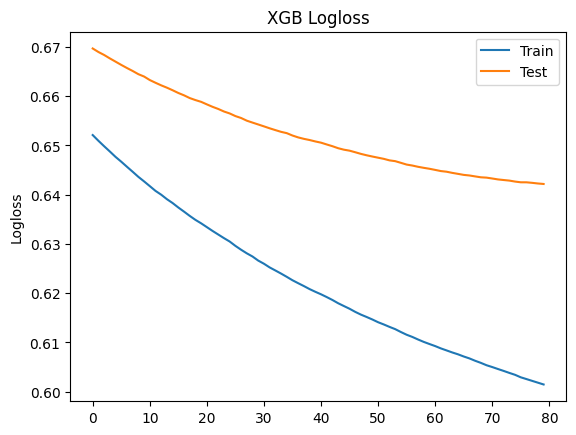

In [27]:
#Plot Log Loss
fig,ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'],label='Train')
ax.plot(x_axis,results['validation_1']['logloss'], label = 'Test')
ax.legend()
plt.ylabel('Logloss')
plt.title('XGB Logloss')
plt.show()

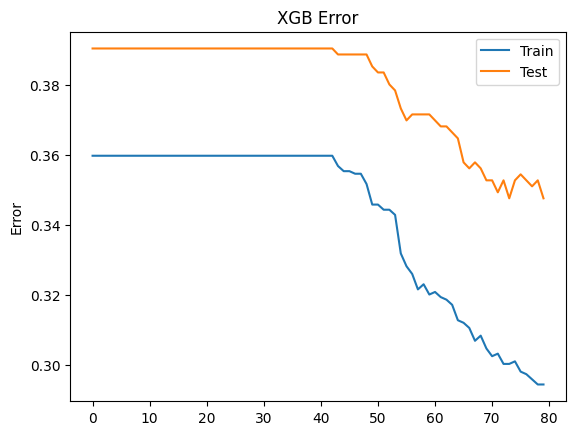

In [28]:
#Plot Classification Error

fig, ax = plt.subplots()
ax.plot(x_axis,results['validation_0']['error'], label = "Train")
ax.plot(x_axis,results['validation_1']['error'], label = 'Test')
ax.legend()
plt.ylabel('Error')
plt.title('XGB Error')
plt.show()


### Evaluation Metrics - ROC Curve

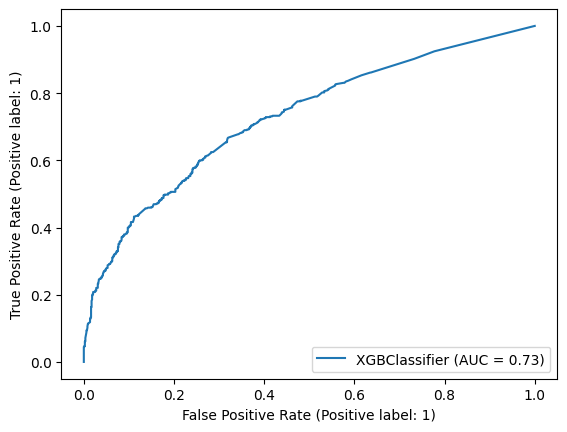

In [29]:
# Plot Training ROC Curve
RocCurveDisplay.from_estimator(classifier,X_train, y_train)

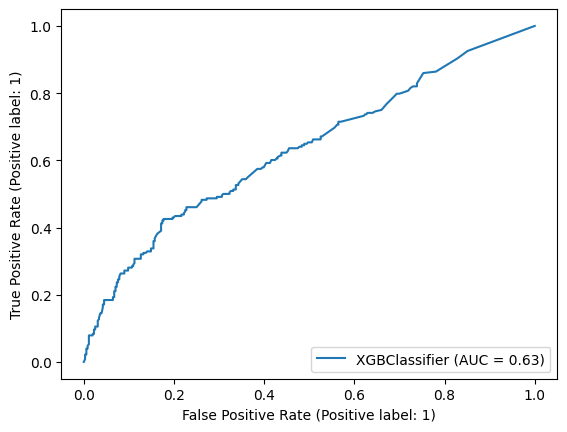

In [30]:
RocCurveDisplay.from_estimator(classifier,X_test, y_test)

### Performance Evaluation

In [31]:
#Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 1)

In [32]:
#Training REsults
train_results = cross_val_score(classifier,X_train,y_train,scoring = scoring, cv = cv, n_jobs = -1)

In [33]:
#Training REsults
test_results = cross_val_score(classifier,X_test,y_test,scoring = scoring, cv = cv, n_jobs = -1)

In [34]:
#Overview
print('TRAIN:')
print('Average Acc K-Fold', round(train_results.mean(),2))
print('Std Dev K-Fold', round(train_results.std(),2))
print('Precision Score 0', round(precision_score(y_train,train_yhat,average = None)[0],3))
print('Precision Score 1', round(precision_score(y_train,train_yhat,average = None)[1],3))
print("----- ----- ----- ----- ----- -----")

print('TEST:')
print('Average Acc K-Fold', round(test_results.mean(),2))
print('Std Dev K-Fold', round(test_results.std(),2))
print('Precision Score 0', round(precision_score(y_test,test_yhat,average = None)[0],3))
print('Precision Score 1', round(precision_score(y_test,test_yhat,average = None)[1],3))
print("----- ----- ----- ----- ----- -----")

TRAIN:
Average Acc K-Fold 0.71
Std Dev K-Fold 0.06
Precision Score 0 0.696
Precision Score 1 0.773
----- ----- ----- ----- ----- -----
TEST:
Average Acc K-Fold 0.6
Std Dev K-Fold 0.21
Precision Score 0 0.651
Precision Score 1 0.662
----- ----- ----- ----- ----- -----


### Evaluation Metrics - Summary Report

In [35]:
#Show summary report - Training
print(classification_report(y_train,train_yhat))

              precision    recall  f1-score   support

         0.0       0.70      0.96      0.81       872
         1.0       0.77      0.26      0.39       490

    accuracy                           0.71      1362
   macro avg       0.73      0.61      0.60      1362
weighted avg       0.72      0.71      0.66      1362



In [36]:
#Show summary report - Test

print(classification_report(y_test,test_yhat))

              precision    recall  f1-score   support

         0.0       0.65      0.93      0.76       356
         1.0       0.66      0.22      0.33       228

    accuracy                           0.65       584
   macro avg       0.66      0.58      0.55       584
weighted avg       0.66      0.65      0.60       584



### Performance Evaluation - Confusion Metrics

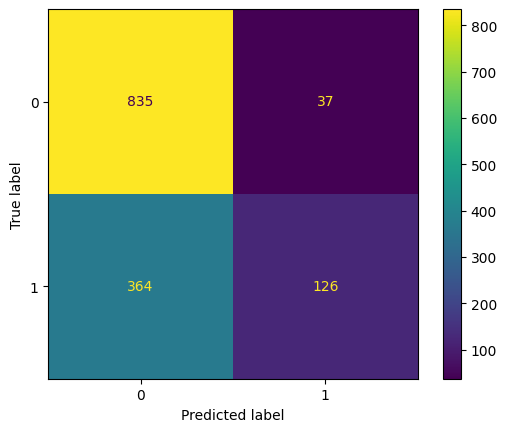

In [37]:
#TRaining Confusion Metrics
cm_train = confusion_matrix(y_train,train_yhat)
ConfusionMatrixDisplay(cm_train).plot()

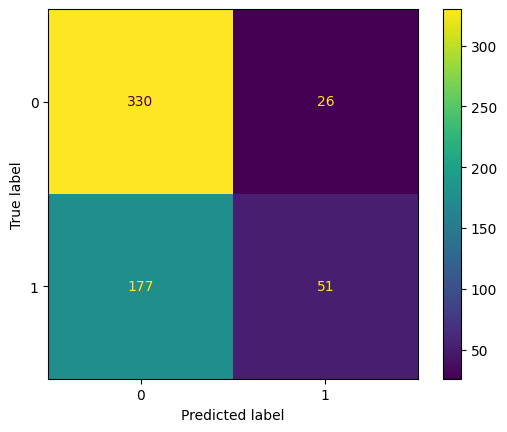

In [38]:
#Test Confusion Metrics
cm_test = confusion_matrix(y_test,test_yhat)
ConfusionMatrixDisplay(cm_test).plot()

### Feature Importance

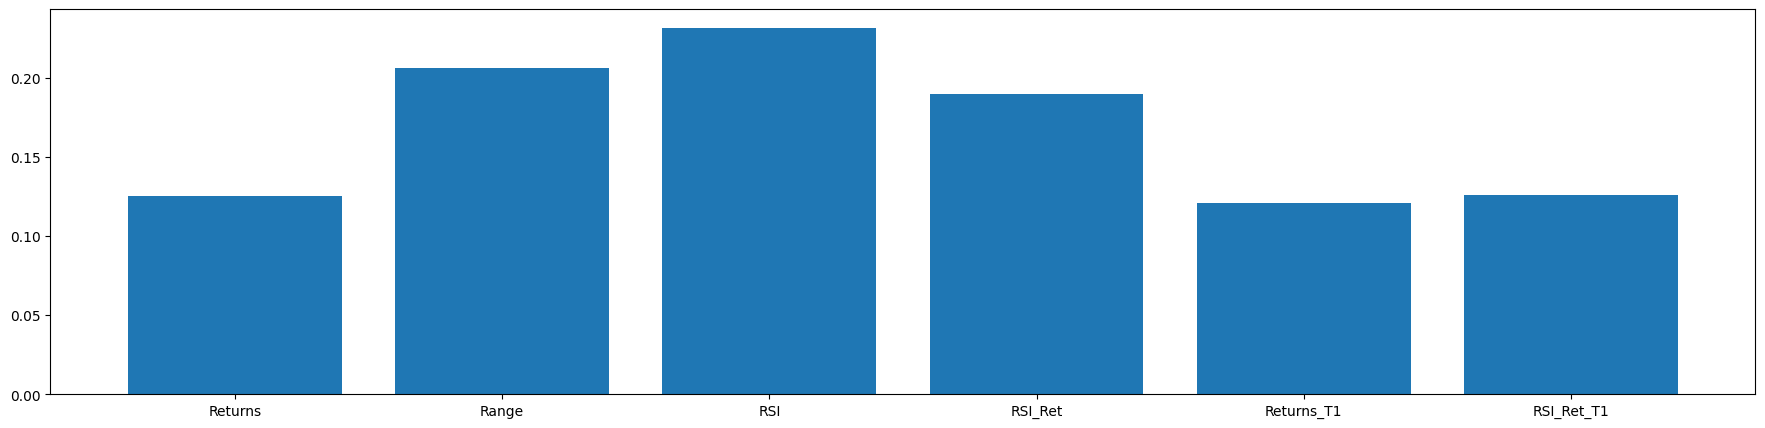

In [39]:
#Plot Feature Importances
fig = plt.figure(figsize = (22,5))
importance_labels = X.columns
importance_features = classifier.feature_importances_
plt.bar(importance_labels,importance_features)
plt.show()

<Axes: >

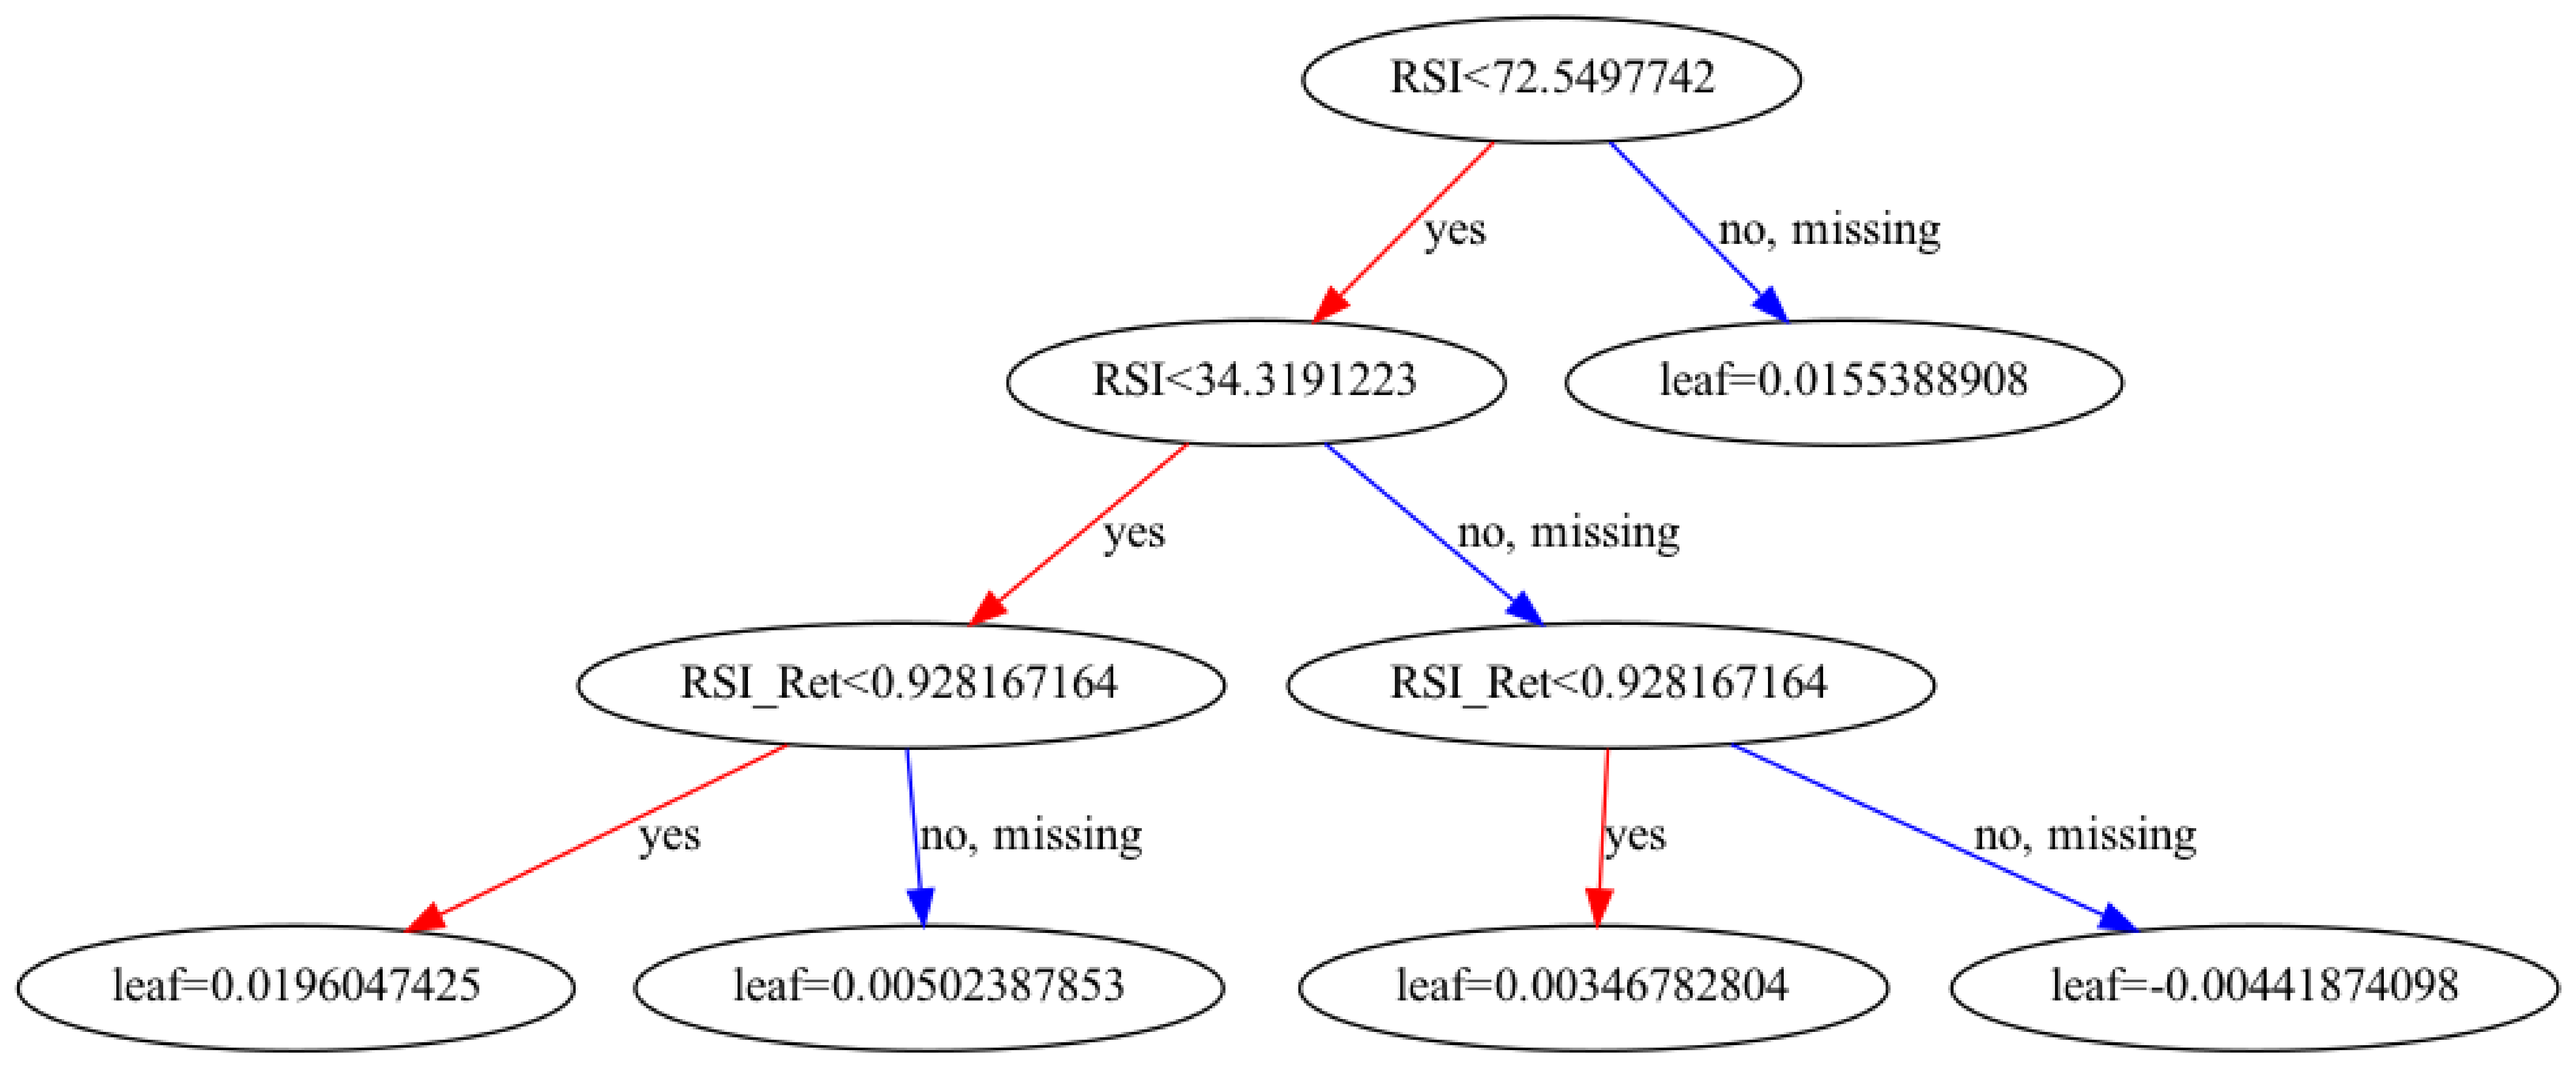

In [42]:
rcParams['figure.figsize'] = 80,50
plot_tree(classifier)
